# Generating lightcone noise samples - Comparing between `tuesday` and `tools21cm`
In this notebook, we compare lightcone noise generation methods from `tools21cm` (master branch on 01/07/25, commit c0cc4d5) with `tuesday`.
We do this using the `AA4` SKA layout. \
We start by importing key modules and defining a plotting function to compare outputs from the two.

In [1]:
import numpy as np
from py21cmsense import Observatory, Observation
from py21cmsense.conversions import f2z, z2f
import astropy.units as un

import matplotlib.pyplot as plt

# Set observation parameters
We choose the SKA layout and set the number of tracking hours. 
Since the goal is to create a lightcone realisation from SKA, the observation frequencies should be chosen according to the frequencies / redshifts of the lightcone.

In [2]:
hours_tracking = 2.*un.hour
observatory = Observatory.from_ska("AA4")

<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__


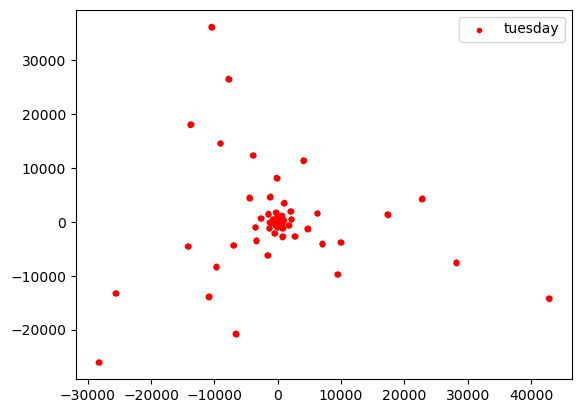

In [3]:
plt.scatter(observatory.antpos[:,0], observatory.antpos[:,1], color = "r", marker = ".", label = "tuesday")
plt.legend()
plt.show()


# Calculating thermal noise in uv space with `tuesday`
With `tuesday`, the user can use the `Observatory` object along with the integration time and daily observation duration to define an `Observation`. 
Here you can optionally set the minimum and/or maximum baselines as well.

In [4]:
from tuesday.core import thermal_noise_uv
from py21cmsense.baseline_filters import BaselineRange

In [5]:
lc_shape = np.array([200,200,20])
boxlength = 300. *un.Mpc
integration_time = 60*un.s
lc_redshifts = np.logspace(np.log10(8.45), np.log10(20), lc_shape[2])
lc_freqs = [z2f(z).to(un.MHz) for z in lc_redshifts]

In [6]:
# Define an observation
obs = Observation(observatory=observatory, 
            time_per_day=hours_tracking,
            lst_bin_size=hours_tracking,
            integration_time=integration_time,
            bandwidth=50 *un.kHz,
            n_days=int(np.ceil(1000/hours_tracking.value)),
            baseline_filters= BaselineRange(bl_min=10.*un.m,bl_max=2000.*un.m),
                 )

In [7]:
sigma_uv = thermal_noise_uv(obs,
    lc_freqs,
    boxlength,
    lc_shape[0],
    min_nbls_per_uv_cell=15
    )

finding redundancies: 100%|██████████| 511/511 [00:00<00:00, 526.23ants/s]
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


# Plot thermal RMS noise

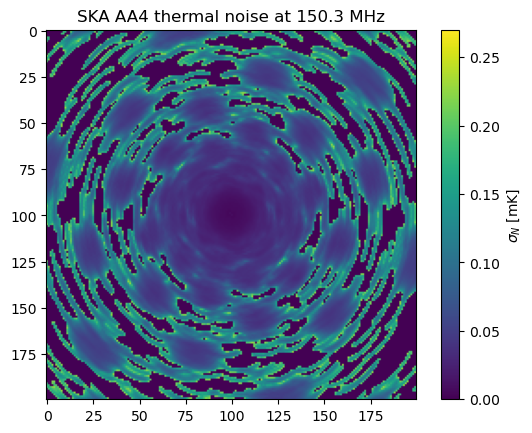

In [8]:
im = plt.imshow(sigma_uv[...,0].value, vmax = 0.27)
plt.colorbar(im, label=r"$\sigma_{N}$ [mK]")
plt.title(f"SKA AA4 thermal noise at {np.round(lc_freqs[0].value,1)} MHz")
plt.show()

# Sample lightcone noise with `tuesday`
With `tuesday` we can control the random generation by setting a random seed manually for reproducibility. If not set, a seed is chosen at random.\
We can also set the number of noise realisations we want with `nsamples`.\
`sample_from_rms_noise` takes as input the thermal noise in uv space that we plotted above and returns only samples of the noise in real or Fourier space.
On the other hand, the `sample_lc_noise` convenience function does the entire noise calculation given an `Observation` and a `lightcone` and returns samples of noisy lightcones, where realisations of thermal noise have been added in Fourier space as in Prelogovic+23.

In [9]:
from tuesday.core import sample_lc_noise

In [10]:
lc = np.random.normal(size=lc_shape) * un.mK

In [11]:
lc_noisy,_ = sample_lc_noise(observation=obs,
                        lightcone=lc,
                        box_len=boxlength,
                        lightcone_redshifts=lc_redshifts,
                        seed=4, 
                        nsamples=10,
                        min_nbls_per_uv_cell=15,
                        )

finding redundancies: 100%|██████████| 511/511 [00:02<00:00, 218.47ants/s]
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


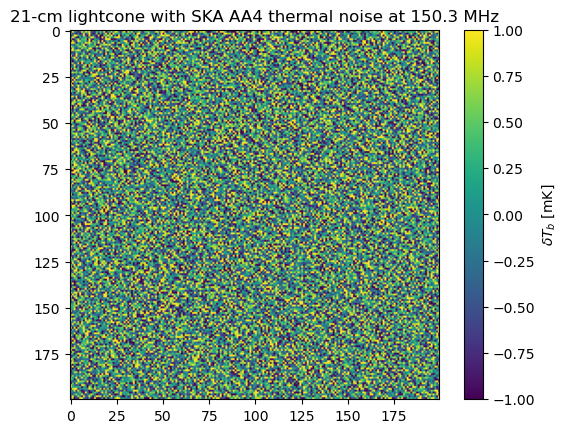

In [12]:
im = plt.imshow(lc_noisy[0,...,0].value, vmax = 1, vmin = -1)
plt.colorbar(im, label=r"$\delta T_b$ [mK]")
plt.title(f"21-cm lightcone with SKA AA4 thermal noise at {np.round(lc_freqs[0].value,1)} MHz")
plt.show()

We can also remove the wedge at the horizon limit and add a 100ns buffer above the horizon limit:

In [13]:
from tuesday.core import horizon_limit

In [14]:
lc_noisy,_ = sample_lc_noise(observation=obs,
                        lightcone=lc,
                        box_len=boxlength,
                        lightcone_redshifts=lc_redshifts,
                        seed=4, 
                        nsamples=10,
                        min_nbls_per_uv_cell=15,
                        remove_wedge=True,
                        wedge_kpar=horizon_limit(buffer=100*un.ns)
                        )

finding redundancies: 100%|██████████| 511/511 [00:02<00:00, 231.59ants/s]
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


WEDGE MASK (200, 20)


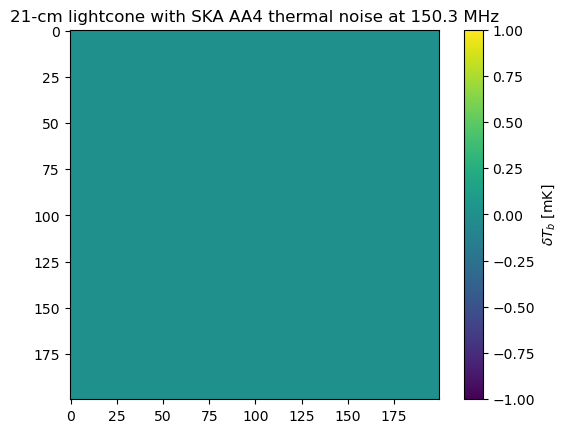

In [16]:
im = plt.imshow(lc_noisy[0,...,0], vmax = 1, vmin = -1)
plt.colorbar(im, label=r"$\delta T_b$ [mK]")
plt.title(f"21-cm lightcone with SKA AA4 thermal noise at {np.round(lc_freqs[0].value,1)} MHz")
plt.show()